# Imports

In [2]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter

---

# Carga de datos

In [3]:
auctions = pd.read_pickle("../../../../data/tp2/auctions_tp2_formateado.pkl")

In [16]:
# Dispositivos de la competencia
targets = pd.read_pickle("../../../../data/tp2/ref_hashes_target.pkl")

---

# Pruebo dispositivos de la competencia solamente en la ventana 1

In [60]:
auctions_competencia_v1 = auctions.loc[(auctions["device_id"].isin(targets.index)) & (auctions["date"].dt.day < 21)]

# Sin Right Censoring

In [149]:
tiempos = pd.DataFrame()
gb = auctions_competencia_v1.groupby("device_id")
for t, g in gb:
    fechas = g["date"]
    #fechas = fechas.append(pd.Series([np.datetime64("2019-04-21 00:00:00.000000")]))    
    fechas = fechas.to_frame();
    fechas["date"] = fechas["date"].sub(fechas["date"].shift())
    #fechas.rename(columns= {0: "duracion"}, inplace=True)
    fechas["date"] = fechas["date"].dt.total_seconds()
    fechas["observado"] = 1
    #fechas.iloc[-1, fechas.columns.get_loc('observado')] = 0
    tiempos = tiempos.append(fechas)

# Armo el modelo

In [152]:
model = KaplanMeierFitter()
tiempos = tiempos.dropna()
model.fit(durations=tiempos["date"], event_observed=tiempos["observado"])

<lifelines.KaplanMeierFitter: fitted with 160585 observations, 0 censored>

---

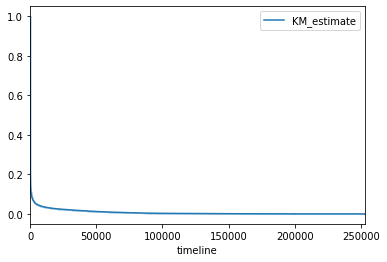

In [173]:
model.plot()

In [142]:
targets_en_v1 = auctions.loc[(auctions["device_id"].isin(targets.index)) & (auctions["date"].dt.day < 21)][["device_id", "date"]]

In [154]:
tiempo_maximo = targets_en_v1.groupby("device_id").agg({"date" :"max"})

In [155]:
tiempo_maximo["sobrevivio_por"] = np.datetime64("2019-04-21 00:00:00.000000") - tiempo_maximo["date"]

In [156]:
tiempo_maximo["sobrevivio_por"] = tiempo_maximo["sobrevivio_por"].dt.total_seconds()

In [167]:
tiempo_maximo["prediccion_probabilidad"] = list(model.predict(tiempo_maximo["sobrevivio_por"]))

In [4]:
auctions_en_v1 = auctions.loc[auctions["device_id"].isin(labels_v1.index)]

In [18]:

gb = auctions_en_v1.groupby("device_id")


NameError: name 'auctions_en_v1' is not defined

In [62]:
vacio = pd.Series()

In [ ]:
i = 0
for t, g in gb:
    vacio = vacio.append(g["date"].sub(g["date"].shift()))
    i += 1
    print("{} persona agregada".format(i))
    if (i == 100):
        break

In [64]:
vacio = vacio.to_frame()

In [66]:
vacio["en_segundos"] = vacio[0].dt.total_seconds()

In [65]:
vacio = vacio.dropna()

In [67]:
model = KaplanMeierFitter()
model.fit(vacio["en_segundos"])

<lifelines.KaplanMeierFitter: fitted with 10090 observations, 0 censored>

In [68]:
resultados = model.conditional_time_to_event_

# Pruebo con 10.000 individuos, tiempos de todas las ventanas. Desupes probar con solo v1

In [243]:
sampled_targets = labels_v1

In [277]:
ventana_1 = auctions.loc[auctions["dia"] < 21]

In [280]:
labels_v1["n_apariciones"] = ventana_1.groupby("device_id").agg({"dia" : "count"})

In [283]:
muy_aparecidos = labels_v1.loc[labels_v1["n_apariciones"] > 3000]

In [ ]:
len(muy_aparecidos)

In [ ]:
predicciones = []
for j in muy_aparecidos.iterrows():
    mini = auctions.loc[auctions["device_id"] == j[0]] #1677316392823000836
    tiempos = (mini["tiempo"] - mini["tiempo"].shift()).fillna(0)
    model = KaplanMeierFitter()
    model.fit(tiempos)
    resutlados = model.conditional_time_to_event_
    ultima_observacion = mini.loc[(mini["dia"] < 20)]["date"].max()
    sobrevivio = (pd.Timestamp("2019-04-20 00:00:00.000000") - ultima_observacion).total_seconds()
    prediccion = resutlados.loc[resutlados.index > sobrevivio].iloc[0][0]
    predicciones.append(prediccion)
    

In [304]:
len(predicciones)

64

In [305]:
deltas = muy_aparecidos["target"].iloc[:64].values - predicciones

In [306]:
total = 0
for x in deltas:
    total += (x**2)

In [307]:
sqrt(total/64)

28842.80969620438